# 数值积分

In [1]:
from sympy import *

## Newton-Cotes求积公式

- trapezium & simpson

In [2]:
def trapezium_integral(f, a, b):
    """梯形求积公式
    """
    return (b - a) * (f(a) + f(b)) / 2


def simpson_integral(f, a, b):
    """辛普森求积公式
    """
    return (b - a) * (f(a) + 4 * f((a + b) / 2) + f(b)) / 6

- Newton-Cotes

In [3]:
def costes_coefficient(n, k):
    """求柯特斯系数
    """
    ckn = ((-1) ** (n - k))
    ckn /= n * factorial(k) * factorial(n - k)

    h = 1
    t = Symbol('t')
    for j in range(n+1):
        if j != k:
            h *= (t - j)

    ckn *= integrate(h, (t, 0, n))

    return ckn

打出一张表测试科特斯系数：

In [4]:
for i in range(6):
    for j in range(i+2):
        print(costes_coefficient(i+1, j), end= "\t ")
    print()

1/2	 1/2	 
1/6	 2/3	 1/6	 
1/8	 3/8	 3/8	 1/8	 
7/90	 16/45	 2/15	 16/45	 7/90	 
19/288	 25/96	 25/144	 25/144	 25/96	 19/288	 
41/840	 9/35	 9/280	 34/105	 9/280	 9/35	 41/840	 


In [5]:
def newton_cotes_integral(f, a, b, n):
    """牛顿-科特斯求积公式
    """
    step = (b - a) / n
    xs = [a + i * step for i in range(n+1)]
    return (b - a) * sum([
        costes_coefficient(n, k) * f(xs[k]) 
        for k in range(0, n+1)
    ])

牛顿-科特斯求积公式测试：

In [6]:
r = newton_cotes_integral(sin, 0, pi, 10)

x = Symbol('x')
print(abs(r - integrate(sin(x), (x, 0, pi))) < 0.00001)

True


## 复化求积公式



- 复化梯形公式

In [7]:
def composite_trapezium_integral(f, a, b, epsilon, max_iter=10000):
    """ 复化梯形公式

    Args:
        f: 要求积的函数
        a, b: 求积区间
        epsilon: 目标精度，达到则停止，返回积分值
        max_iter: 最大迭代次数，超出这个次数迭代不到目标精度，则 raise 一个 RuntimeError

    Returns:
        i, iter
        i: 最终得到的积分值
        iter_times: 迭代次数

    Raises:
        RuntimeError: 无法在 max_iter 步内迭代到目标精度
    """
    m = 1
    h = b - a
    t = h * (f(a) + f(b)) / 2

    _iter_times = 0
    
    t_next = 0
    for _iter_times in range(int(max_iter)):
        h /= 2
        s = sum([f(a + (2 * k - 1) * h) for k in range(1, m+1)])
        t_next = t / 2 + h * s
        m <<= 1
        if abs(t_next - t) <= epsilon:
            break
        t = t_next
    else:
        raise RuntimeError('无法在 max_iter 步内迭代到目标精度')

    return t_next, _iter_times+1

测试复化梯形公式：

In [8]:
def f(x):
    return x ** 2

x = Symbol('x')
a = integrate(f(x), (x, 0, 1))

t = composite_trapezium_integral(f, 0, 1, 0.0001)
print(f"result_composite_trapezium_integral = {t}, actual: {a}")

result_composite_trapezium_integral = (0.333343505859375, 7), actual: 1/3


- 复化 Simpson 公式

In [9]:
def composite_simpson_integral(f, a, b, epsilon, max_iter=1e6):
    """复化 Simpson 公式

    Args:
        f: 要求积的函数
        a, b: 求积区间
        epsilon: 目标精度，达到则停止，返回积分值
        max_iter: 最大迭代次数，超出这个次数迭代不到目标精度，则 raise 一个 RuntimeError

    Returns:
        i, iter
        i: 最终得到的积分值
        iter_times: 迭代次数

    Raises:
        RuntimeError: 无法在 max_iter 步内迭代到目标精度
    """
    m = 1
    h = (b - a) / 2
    i = h * (f(a) + 4 * f((a+b) / 2) + f(b)) / 3
    
    _iter_times = 0

    i_next = 0
    for _iter_times in range(int(max_iter)):
        h /= 2

        s0 = sum([f(a + (2 * k - 1) * h) for k in range(1, 2 * m + 1)])
        s1 = sum([f(a + (4 * k - 2) * h) for k in range(1, m + 1)])
        i_next = i / 2 + h * (4 * s0 - 2 * s1) / 3
        
        m <<= 1
        if abs(i_next - i) <= epsilon:
            break
        i = i_next
    else:
        raise RuntimeError('无法在 max_iter 步内迭代到目标精度')

    return i_next, _iter_times+1

In [10]:
def f(x):
    return 3 * x ** 3 - 2 * x + sin(x)

x = Symbol('x')
a = integrate(f(x), (x, 0, 1))

t, times = composite_simpson_integral(f, 0, 1, 0.0001)
print(f"result_composite_simpson_integral = {t}, actual: {a}\ndiff < 0.0001: {abs(t-a) < 0.0001}")

result_composite_simpson_integral = 0.0416666666666667*sin(1) + 0.174637027764799, actual: 3/4 - cos(1)
diff < 0.0001: True


龙贝格算法

In [11]:
def romberg_integral(f, a, b, epsilon, max_iter=1e6):
    """Romberg 积分

    Args:
        f: 要求积的函数
        a, b: 求积区间
        epsilon: 目标精度，达到则停止，返回积分值
        max_iter: 最大迭代次数，超出这个次数迭代不到目标精度，则 raise 一个 RuntimeError

    Returns:
        result, T, iter
        
        result: 最终得到的积分值
        T: 计算过程表
        iter_times: 迭代次数

    Raises:
        RuntimeError: 无法在 max_iter 步内迭代到目标精度
    """
    m = 0

    T = [[None] * 4]
    T[0][0] = (b - a) * (f(a) + f(b)) / 2

    for m in range(1, int(max_iter)):
        T.append([None] * 4)
        
        h = (b - a) / (2 ** m)
        
        _s = sum((f(a + (2 * k - 1) * h) for k in range(1, 1 + 2**(m-1))))
        T[m][0] = T[m-1][0] / 2 + h * _s
        
        _t = 4      # 4 ** 1
        T[m-1][1] = (_t * T[m][0] - T[m-1][0]) / (_t - 1)

        if m > 1:
            _t *= 4  # 4 ** 2
            T[m-2][2] = (_t * T[m-1][1] - T[m-2][1]) / (_t - 1)
        if m > 2:
            _t *= 4  # 4 ** 3
            T[m-3][3] = (_t * T[m-2][2] - T[m-3][2]) / (_t - 1)
        
        if (m > 3) and (abs(T[m-3][3] - T[m-4][3]) < epsilon):
            break
        # End for
    else:
        raise RuntimeError('无法在 max_iter 步内迭代到目标精度')

    return T[m-3][3], T, m

In [12]:
import math

def f(x):
    return 3 * x ** 3 - 2 * x + sin(x)

x = Symbol('x')
a = integrate(f(x), (x, 2, 10))

t, T, iter_times = romberg_integral(f, 2, 10, 1e-10)
print(f"result_romberg_integral = {t}, actual: {a}\ndiff < 0.0001: {abs(t-a) < 0.0001}")
print(iter_times, len(str(T)))
print(T)

result_romberg_integral = 31*sin(10)/1620 + 31*sin(2)/1620 + 7392.4159348371, actual: cos(2) - cos(10) + 7392
diff < 0.0001: True
7 1216
[[4*sin(10) + 4*sin(2) + 12000, 4*sin(10)/3 + 4*sin(2)/3 + 7390.50978400961, 28*sin(10)/45 + 28*sin(2)/45 + 7392.36344871677, 124*sin(10)/405 + 124*sin(2)/405 + 7392.30668995305], [2*sin(10) + 2*sin(2) + 8542.8823380072, 2*sin(10)/3 + 2*sin(2)/3 + 7392.24759467258, 14*sin(10)/45 + 14*sin(2)/45 + 7392.30757680873, 62*sin(10)/405 + 62*sin(2)/405 + 7392.36701663887], [sin(10) + sin(2) + 7679.90628050623, sin(10)/3 + sin(2)/3 + 7392.30382792522, 7*sin(10)/45 + 7*sin(2)/45 + 7392.36608789152, 31*sin(10)/405 + 31*sin(2)/405 + 7392.39496529595], [sin(10)/2 + sin(2)/2 + 7464.20444107047, sin(10)/6 + sin(2)/6 + 7392.36219664363, 7*sin(10)/90 + 7*sin(2)/90 + 7392.39451408651, 31*sin(10)/810 + 31*sin(2)/810 + 7392.40894498176], [sin(10)/4 + sin(2)/4 + 7410.32275775034, sin(10)/12 + sin(2)/12 + 7392.39249424633, 7*sin(10)/180 + 7*sin(2)/180 + 7392.40871949902, 31

In [13]:
def romberg_integral_sw(f, a, b, epsilon, max_iter=1e6):
    """Romberg 积分

    用滑动窗口改写了 romberg_integral。
    在计算的过程中，不断删除不再需要的值，
    对于需要多次迭代的问题，可以有效节省内存。

    Args:
        f: 要求积的函数
        a, b: 求积区间
        epsilon: 目标精度，达到则停止，返回积分值
        max_iter: 最大迭代次数，超出这个次数迭代不到目标精度，则 raise 一个 RuntimeError

    Returns:
        result, T, iter

        result: 最终得到的积分值
        T: 计算过程表（只有最后的 m-4 到 m 步）
        iter_times: 迭代次数

    Raises:
        RuntimeError: 无法在 max_iter 步内迭代到目标精度
    """
    m = 0

    T = [[None] * 4]
    T[0][0] = (b - a) * (f(a) + f(b)) / 2

    for m in range(1, int(max_iter)):
        T.append([None] * 4)
        # 下面的索引 T[-1] 即 T_m, T[-2] 即 T_{m-1}, ...
        
        h = (b - a) / (2 ** m)
        
        _s = sum((f(a + (2 * k - 1) * h) for k in range(1, 1 + 2**(m-1))))
        T[-1][0] = T[-2][0] / 2 + h * _s
        
        _t = 4      # 4 ** 1
        T[-2][1] = (_t * T[-1][0] - T[-2][0]) / (_t - 1)

        if m > 1:
            _t *= 4  # 4 ** 2
            T[-3][2] = (_t * T[-2][1] - T[-3][1]) / (_t - 1)
        if m > 2:
            _t *= 4  # 4 ** 3
            T[-4][3] = (_t * T[-3][2] - T[-4][2]) / (_t - 1)
        
        if (m > 3) and (abs(T[-4][3] - T[-5][3]) < epsilon):
            break

        if (m > 4):
            T = T[1:] # 清除不需要的
        # End for
    else:
        raise RuntimeError('无法在 max_iter 步内迭代到目标精度')

    return T[-4][3], T, m

In [14]:
import math

def f(x):
    return 3 * x ** 3 - 2 * x + sin(x)

x = Symbol('x')
a = integrate(f(x), (x, 2, 10))

t, T, iter_times = romberg_integral_sw(f, 2, 10, 1e-10)
print(f"result_romberg_integral_sw = {t}, actual: {a}\ndiff < 0.0001: {abs(t-a) < 0.0001}")
print(iter_times, len(str(T)))
print(T)

result_romberg_integral_sw = 31*sin(10)/1620 + 31*sin(2)/1620 + 7392.4159348371, actual: cos(2) - cos(10) + 7392
diff < 0.0001: True
7 850
[[sin(10) + sin(2) + 7679.90628050623, sin(10)/3 + sin(2)/3 + 7392.30382792522, 7*sin(10)/45 + 7*sin(2)/45 + 7392.36608789152, 31*sin(10)/405 + 31*sin(2)/405 + 7392.39496529595], [sin(10)/2 + sin(2)/2 + 7464.20444107047, sin(10)/6 + sin(2)/6 + 7392.36219664363, 7*sin(10)/90 + 7*sin(2)/90 + 7392.39451408651, 31*sin(10)/810 + 31*sin(2)/810 + 7392.40894498176], [sin(10)/4 + sin(2)/4 + 7410.32275775034, sin(10)/12 + sin(2)/12 + 7392.39249424633, 7*sin(10)/180 + 7*sin(2)/180 + 7392.40871949902, 31*sin(10)/1620 + 31*sin(2)/1620 + 7392.4159348371], [sin(10)/8 + sin(2)/8 + 7396.87506012233, sin(10)/24 + sin(2)/24 + 7392.40770542073, 7*sin(10)/360 + 7*sin(2)/360 + 7392.41582209745, None], [sin(10)/16 + sin(2)/16 + 7393.52454409613, sin(10)/48 + sin(2)/48 + 7392.41531480515, None, None], [sin(10)/32 + sin(2)/32 + 7392.6926221279, None, None, None]]


题目 4.4 实验内容和步骤

$$
I_1 = \int_0^1 e^{-x^2} dx
$$

In [15]:
import math

def f1(x):
    if not isinstance(x, float):
        x = float(x)
    return math.exp(-x ** 2)

result_trapezium = trapezium_integral(f1, 0, 1)
result_simpson = simpson_integral(f1, 0, 1)
result_composite_simpson, times_composite_simpson = composite_simpson_integral(f1, 0, 1, 1e-6)
result_composite_trapezium, times_composite_trapezium = composite_trapezium_integral(f1, 0, 1, 1e-6)
result_romberg, _, times_romberg = romberg_integral(f1, 0, 1, 1e-6)

actual = integrate(exp(-Symbol('x') ** 2), (Symbol('x'), 0, 1))

print(f'''integral exp(-x ** 2) dx from 0 to 1

actual result (by sympy): {actual} = {actual.evalf()}

result_trapezium={result_trapezium}
result_simpson={result_simpson}
result_composite_trapezium={result_composite_trapezium}, times_composite_trapezium={times_composite_trapezium}
result_composite_simpson={result_composite_simpson}, times_composite_simpson={times_composite_simpson}
result_romberg={result_romberg}, times_romberg={times_romberg}
''')

integral exp(-x ** 2) dx from 0 to 1

actual result (by sympy): sqrt(pi)*erf(1)/2 = 0.746824132812427

result_trapezium=0.6839397205857212
result_simpson=0.7471804289095104
result_composite_trapezium=0.7468238989209475, times_composite_trapezium=9
result_composite_simpson=0.7468241406069852, times_composite_simpson=4
result_romberg=0.7468241326473878, times_romberg=4



$$
I_2 = \int_0^1 \frac{\sin(x)}{x} dx
$$

In [16]:
def f2(x):
    if not isinstance(x, float):
        x = float(x)
    return math.sin(x) / x

result_trapezium = trapezium_integral(f2, 1e-32, 1)
result_simpson = simpson_integral(f2, 1e-32, 1)
result_composite_simpson, times_composite_simpson = composite_simpson_integral(f2, 1e-32, 1, 1e-6)
result_composite_trapezium, times_composite_trapezium = composite_trapezium_integral(f2, 1e-32, 1, 1e-6)
result_romberg, _, times_romberg = romberg_integral(f2, 1e-32, 1, 1e-6)

actual = integrate(sin(Symbol('x')) / Symbol('x'), (Symbol('x'), 0, 1))

print(f'''integral sin(x) / x dx from 0 to 1

actual result (by sympy): {actual} = {actual.evalf()}

result_trapezium={result_trapezium}
result_simpson={result_simpson}
result_composite_trapezium={result_composite_trapezium}, times_composite_trapezium={times_composite_trapezium}
result_composite_simpson={result_composite_simpson}, times_composite_simpson={times_composite_simpson}
result_romberg={result_romberg}, times_romberg={times_romberg}
''')

integral sin(x) / x dx from 0 to 1

actual result (by sympy): Si(1) = 0.946083070367183

result_trapezium=0.9207354924039483
result_simpson=0.9461458822735868
result_composite_trapezium=0.9460829746282349, times_composite_trapezium=9
result_composite_simpson=0.9460830853849476, times_composite_simpson=3
result_romberg=0.9460830703672595, times_romberg=4



In [17]:
def adaptsim(f, a, b, eps=1e-8, max_iter=10000):
    """自适应 Simpson 求积
    
    P.S. 这个函数名来自 Gander, W. and W. Gautschi, “Adaptive
         Quadrature – Revisited,” BIT, Vol. 40, 2000, pp. 84-101.
         该文档可以在 https://people.inf.ethz.ch/gander/ 找到。
         但该函数的实现并没有使用此文中的递归方法。

    Args:
        f: 要求积的函数
        a, b: 求积区间
        eps: 目标精度，达到则停止，返回积分值
        max_iter: 最大迭代次数，超出这个次数迭代不到目标精度，则 raise 一个 Exception

    Returns: (I, m, p)
        I: 积分的近似值
        m: 分层数
        p: 分点

    Raises:
        Exception: 无法在 max_iter 步内迭代到目标精度
    """
    p = [a, b]  # 分点
    p0 = p
    ep = [eps]
    m = 0
    q = 0
    I = 0
    
    for _iter_times in range(int(max_iter)):
        n1 = len(ep)
        n = len(p0)
        
        if n <= 1:
            break
        
        h = p0[1] - p0[0]
        s0 = h /  6 * ( f(p0[0]) + 4 * f(p0[0] + h/2) + f(p0[0] + h  ) )
        s1 = h / 12 * ( f(p0[0]) + 4 * f(p0[0] + h/4) + f(p0[0] + h/2) )
        s2 = h / 12 * ( f(p0[0] + h/2) + 4 * f(p0[0] + 3*h/4) + f(p0[0] + h) )
        
        if abs(s0 - s1 - s2) <= 15 * ep[0]:
            I += s1 + s2
            p0 = p0[1:]
            
            if n1 >= 2:
                ep = ep[1:]
            
            q += 1
        else:
            m += 1
            p0 = [p0[0], p0[0] + h/2] + p0[1:]
            
            if n1 == 1:
                ep = [ep[0]/2, ep[0]/2]
            else:
                ep = [ep[0]/2, ep[1]/2] + ep[1:]
            
            if q == 0:
                p = p0
            else:
                p = p[:q] + p0
        
    else:
        raise Exception('无法在 max_iter 步内迭代到目标精度')

    return I, m, p

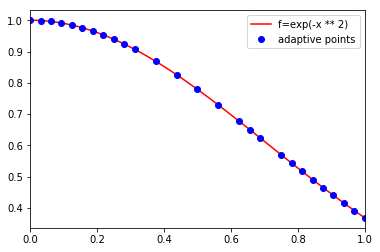

In [18]:
import math
import numpy as np

def f(x):
    if not isinstance(x, float):
        x = float(x)
    return math.exp(-x ** 2)

# actual result (by sympy): sqrt(pi)*erf(1)/2 = 0.746824132812427

I, m, p = adaptsim(f, 0, 1, eps=1e-9)

# 画图
import matplotlib.pyplot as plt

xf = np.linspace(0, 1)
yf = [f(x) for x in xf]

yp = [f(x) for x in p]

plt.plot(xf, yf, 'r-', label='f=exp(-x ** 2)')
plt.plot(p, yp, 'bo', label='adaptive points')
plt.legend()
plt.xlim(0, 1)
plt.show()

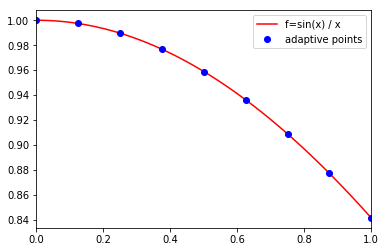

In [19]:
import math

def f(x):
    if not isinstance(x, float):
        x = float(x)
    return math.sin(x) / x

# actual result (by sympy): Si(1) = 0.946083070367183

I, m, p = adaptsim(f, 1e-64, 1)

# 画图
import matplotlib.pyplot as plt

xf = np.linspace(1e-64, 1)
yf = [f(x) for x in xf]

yp = [f(x) for x in p]

plt.plot(xf, yf, 'r-', label='f=sin(x) / x')
plt.plot(p, yp, 'bo', label='adaptive points')
plt.legend()
plt.xlim(0, 1)
plt.show()

I=-1.4260192969841916


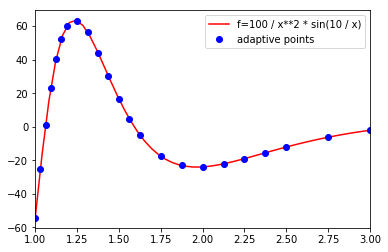

In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return (100 / x**2) * math.sin(10 / x)

I, m, p = adaptsim(f, 1, 3, eps=1e-4)
print(f'I={I}')

xf = np.linspace(1, 3)
yf = [f(x) for x in xf]

yp = [f(x) for x in p]

plt.plot(xf, yf, 'r-', label='f=100 / x**2 * sin(10 / x)')
plt.plot(p, yp, 'bo', label='adaptive points')
plt.legend()
plt.xlim(1, 3)
plt.show()

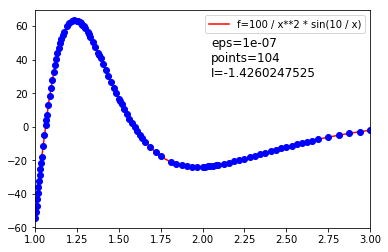

In [21]:
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def f(x):
    return (100 / x**2) * math.sin(10 / x)

fig = plt.figure()

xf = np.linspace(1, 3)
yf = [f(x) for x in xf]
plt.plot(xf, yf, 'r-', label='f=100 / x**2 * sin(10 / x)')
plt.legend()
plt.xlim(1, 3)

text_pt = plt.text(2.05, 30, '', fontsize=12)

adaptsim_points, = plt.plot([1], [f(1)], 'bo', label='adaptsim points')

def update_adaptsim(i):
    eps = 10 ** (-int(i))
    
    I, m, p = adaptsim(f, 1, 3, eps=eps)
    yp = [f(x) for x in p]
    
    adaptsim_points.set_data(p, yp)
    text_pt.set_text(f"eps={eps}\npoints={m}\nI={I: .10f}")
    
    return adaptsim_points,
    
ani = animation.FuncAnimation(fig, update_adaptsim, np.arange(0, 8), interval=200, blit=True)

ani.save('adaptsim.gif', writer='imagemagick', fps=2)
# plt.show()

In [22]:
def asr(f, a, b, eps=1e-8):
    def simpson(f, a, b):
        return (b - a) * (f(a) + 4 * f((a + b) / 2) + f(b)) / 6
    
    def asrp(f, a, b, eps, sim):
        mid = (a + b) / 2
        L = simpson(f, a, mid)
        R = simpson(f, mid, b)

        if (abs(L + R - sim) <= eps):
            return L + R + (L + R - sim) / 15
        
        return asrp(f, a, mid, eps/2, L) + asrp(f, mid, b, eps/2, R)
    
    return asrp(f, a, b, eps, simpson(f, a, b))

In [23]:
asr(lambda x: math.exp(-x ** 2), 0, 1)
# actual result (by sympy): sqrt(pi)*erf(1)/2 = 0.746824132812427

0.7468241328125185

In [24]:
asr(lambda x: math.sin(x) / x, 1e-64, 1)
# actual result (by sympy): Si(1) = 0.946083070367183

0.9460830703671792

In [25]:
asr(lambda x: (100 / x**2) * math.sin(10 / x), 1, 3)

-1.42602475634631